**Desenvolvido Por:**  
_Matheus Gama Costa_  

**Importando bibliotecas**  
Nessa parte as bibliotecas básicas utilizadas para a construção do código são importada.  
Foram utilizadas _numpy_ para trabalharmos com vetores e a parte matemática, _math_ para alguns operadores matemáticos, _matplotlib_ para plotar os gráficos, e a _signal_ do _scipy_ para operações com sinais.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import signal
from scipy.ndimage import label
import scipy.fftpack    
from scipy.signal import find_peaks
import pywt

A partir do sinal de ECG de três canais, X, Y e Z simultâneos, com cinco minutos de duração e amostrados a 1000 amostras/seg., serão implementados as seguintes operações:

1. Interpolação do sinal original para 4000 amostras/seg.;
  
2. Algoritmo para detectar cada batimento, enquadrar, alinhar e promediar o complexo PQRST; apresentando o sinal promediado, número de complexos incluídos na promediação, número de rejeitados, estimativa do ruído residual, calcula-se então o vetor magnitude utilizando as frequências para um filtro passa-alta de 25, 40 e 80Hz;
  
3. Determinação em *milliseconds* os intervalos RR consecutivos do registro e o gráfico RR x Tempo;
  
4. Algoritmo para detecção de todos os intervalos QT nos três canais de ECG. Cálculo do QT corrigido (QTc) usando a correção definida por Bazett. Determinação da duração do QRS;
  
5. Calculo da média, desvio padrão, variância e valor RMS para os sinais RR original e filtrado, utilizando um filtro MA de 3 termos, para 5 minutos e em intervalos de 1 minuto para ambos os sinais

6. Seleção dos intervalos RR para a faixa: MRR-2dpad< RR < MRR+ 2dpad;

**1 - Interpolando o Sinal**  
Para isso será utilizada a função resample da biblioteca de sinais do *scipy* (*scipy.signal*). Após a operação de reamostragem também optou-se por aplicar dois filtros, um Buterwoth de terceira ordem passa faixa, na faixa de 0.1 - 250 Hz, após ele foi aplicado um filtro rejeita faixa de 50 Hz. Ambos os filtros são implementados utilizando funções da biblioteca de sinais sitada anteriormente. Os sinais filtrados foram divididos em quatro vetores diferentes, um para cada canal, e um para o tempo

In [3]:
##############################################################
########## Leitura e tratamento inicial do sinal #############
##############################################################
# leitura Sinal ECG
ecg = pd.read_csv("ECG_XYZ.txt",delimiter="\t")
#Variáveis
fs = 1000 #Frequência de amostragem do sinal
fs_interp = 4000 #Frequencia para o sinl interpolado
# Reamostrando o sinal para a frequência de 40000 Hz
ecg_time = signal.resample(ecg['SamplingInterval'], int(ecg['SamplingInterval'].size/(fs/fs_interp)))
ecg_ref = signal.resample(ecg['RefChXGain1000Inverted'], int(ecg['RefChXGain1000Inverted'].size/(fs/fs_interp)))
ecg_x = signal.resample(ecg['ChXGain5000'], int(ecg['ChXGain5000'].size/(fs/fs_interp)))
ecg_y = signal.resample(ecg['ChYGain5000'], int(ecg['ChYGain5000'].size/(fs/fs_interp)))
ecg_z = signal.resample(ecg['ChZGain5000'], int(ecg['ChZGain5000'].size/(fs/fs_interp)))

# Eliminação linha de base com filtro BP buterwoth
fb = 0.1  # freq. baixa/inferior
fa = 250  # freq. alta/superior
N = 3      # ordem/2
nyq = fs_interp/2
b, a = signal.butter(N, [fb/nyq, fa/nyq], 'bandpass')#calculando filtro butter
#aplicando filtro butter
ecg_ref = signal.filtfilt(b, a, ecg_ref)
ecg_x = signal.filtfilt(b, a, ecg_x)
ecg_y = signal.filtfilt(b, a, ecg_y)
ecg_z = signal.filtfilt(b, a, ecg_z)

notch_freq = 50.0  # Frequency to be removed from signal (Hz)
quality_factor = 30.0  # Quality factor
b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, fs_interp) # cálculando filtro noth
#aplicando filtro notch
ecg_ref = signal.filtfilt(b_notch, a_notch, ecg_ref)
ecg_x = signal.filtfilt(b_notch, a_notch, ecg_x)
ecg_y = signal.filtfilt(b_notch, a_notch, ecg_y)
ecg_z = signal.filtfilt(b_notch, a_notch, ecg_z)

A seguir serão apresentado os gráficos dos sinais interpolados, com suas amostra marcadas, para o intermalo entre os minutos 03:00 e 03:10. Os gráficos são apresentados separadamente para cada canal com o título informando a frequência que foi amostrado ou interpolado.

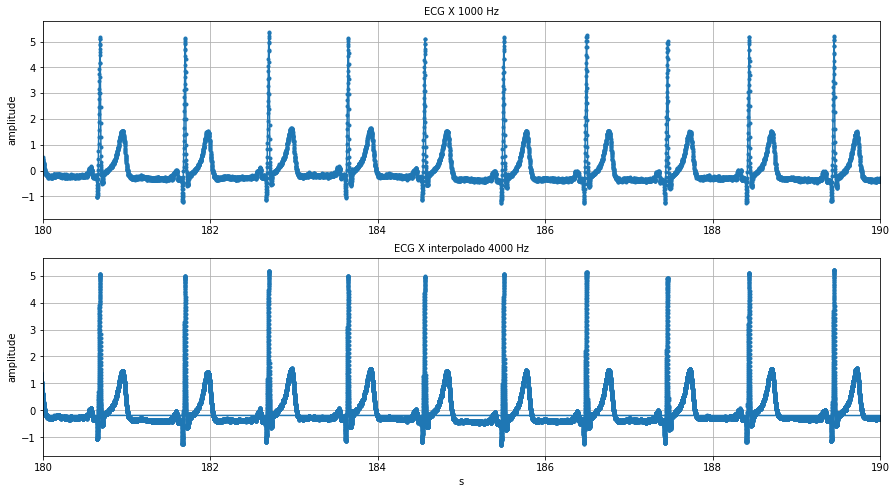

In [6]:
##############################################################
################# Plota sinal reamostrado X ##################
##############################################################
#Plot do ECG
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
#ECG X original
plt.plot(ecg['SamplingInterval'], ecg['ChXGain5000'], '-o', markersize=3.0)
plt.title('ECG X 1000 Hz', fontdict = {'fontsize': 10})
plt.xlim([3*60, (3*60+10)])
plt.ylabel('amplitude')
plt.grid()
#ECG X interp
plt.subplot(2, 1, 2)
plt.plot(ecg_time, ecg_x, '-o', markersize=3.0)
plt.title('ECG X interpolado 4000 Hz', fontdict = {'fontsize': 10})
plt.xlabel('s')
plt.xlim([3*60, (3*60+10)])
plt.ylabel('amplitude')
plt.grid()

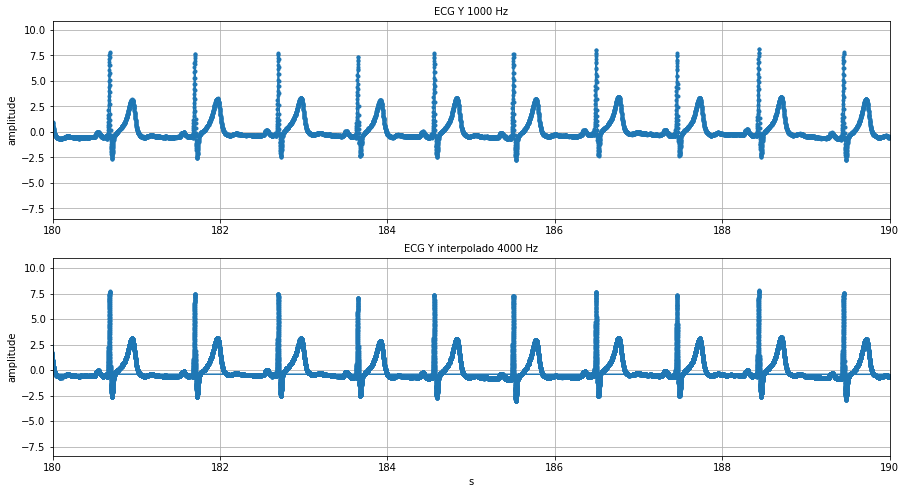

In [7]:
##############################################################
################# Plota sinal reamostrado Y ##################
##############################################################
plt.figure(figsize=(15, 8))
#ECG Y original
plt.subplot(2, 1, 1)
plt.plot(ecg['SamplingInterval'], ecg['ChYGain5000'], '-o', markersize=3.0)
plt.title('ECG Y 1000 Hz', fontdict = {'fontsize': 10})
plt.ylabel('amplitude')
plt.xlim([3*60, (3*60+10)])
plt.grid()
#ECG Y interp
plt.subplot(2, 1, 2)
plt.plot(ecg_time, ecg_y, '-o', markersize=3.0)
plt.title('ECG Y interpolado 4000 Hz', fontdict = {'fontsize': 10})
plt.xlabel('s')
plt.xlim([3*60, (3*60+10)])
plt.ylabel('amplitude')
plt.grid()

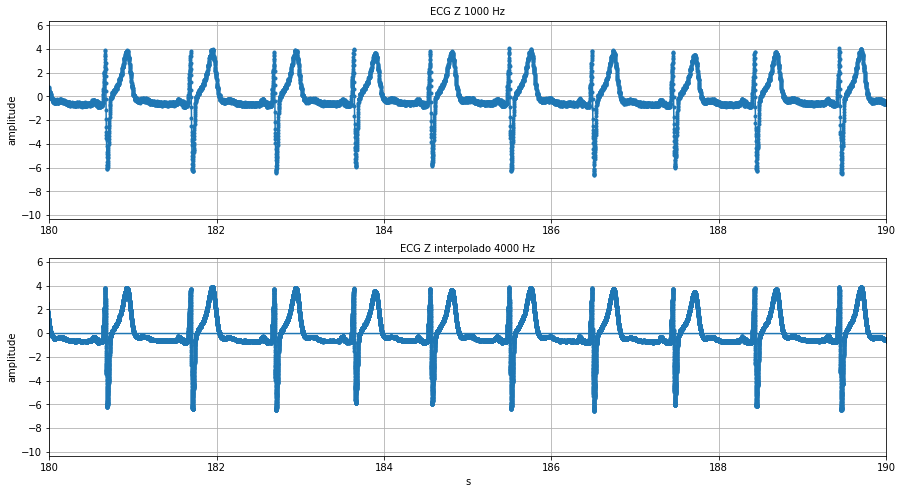

In [8]:
##############################################################
################# Plota sinal reamostrado Z ##################
##############################################################
plt.figure(figsize=(15, 8))
#ECG Z original
plt.subplot(2, 1, 1)
plt.plot(ecg['SamplingInterval'], ecg['ChZGain5000'], '-o', markersize=3.0)
plt.title('ECG Z 1000 Hz', fontdict = {'fontsize': 10})
plt.ylabel('amplitude')
plt.xlim([3*60, (3*60+10)])
plt.grid()
#ECG Z interp
plt.subplot(2, 1, 2)
plt.plot(ecg_time, ecg_z, '-o', markersize=3.0)
plt.title('ECG Z interpolado 4000 Hz', fontdict = {'fontsize': 10})
plt.xlabel('s')
plt.xlim([3*60, (3*60+10)])
plt.ylabel('amplitude')
plt.grid()

**2 - Encontrando os batimentos**  
Para isso foi criada a função *find_beats()* onde o sinal de cada canal pode ser inserido para a identificação dos batimentos. Para a implementação da função utilizou-se a função *find_peaks* da biblioteca de sinais utilizada, essa função identifica os picos presentes no sinal, configuramos ela para identificar os picos com amplitute maiores que 45% do valor máximo do sinal que ela recebe.

In [9]:
##############################################################
########## Função para identificação dos batimentos ##########
##############################################################
def find_beats(ecg):
    a = np.max(ecg)
    peaks, _= find_peaks(ecg, distance=100, height=(a*0.45))#encontra picos no sinal acima de 45% do valor máximo
    
    return peaks

Com essa função identificamos 292 batimentos no sinal de referência, e como os sinais foram adiquiridos simultaneamente utilizamos extrapolamos os picos identificados para os demais sinais. É valido lembrar que primei tivemos de inverter o canal de referência para que a função funcionasse corretamente. A seguir podemos ver o sinal de referência completo com os picos identificados e uma aproximação entre os minutos 03:00 e 03:10

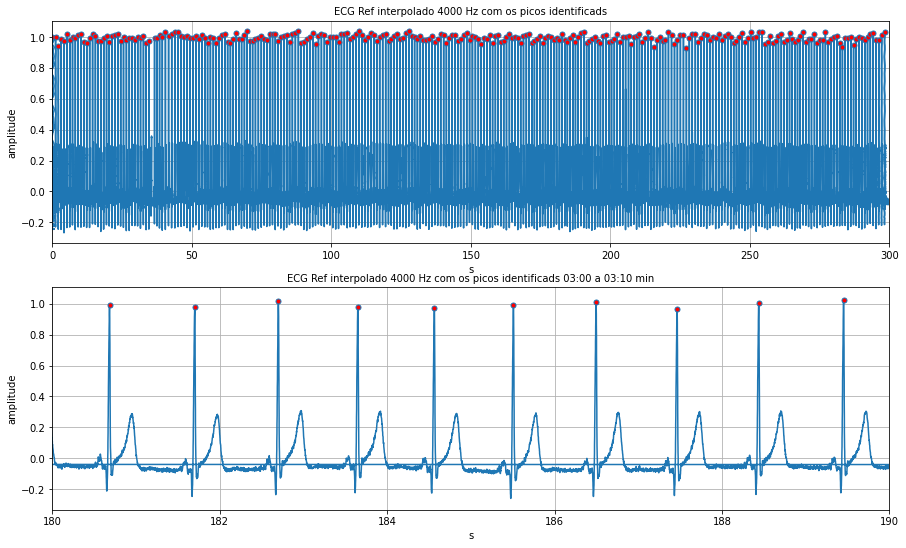

In [13]:
##############################################################
######## Plota e identifica os picos R no sinal de ref #######
##############################################################
if max(ecg_ref)<abs(min(ecg_ref)):
    ecg_ref = -ecg_ref#inverte o sinal de referência

idx_beats = find_beats(ecg_ref)#enconta os batimentos

plt.figure(figsize=(15, 9))
plt.subplot(2, 1, 1)
plt.plot(ecg_time, ecg_ref, '-o',markevery=idx_beats, markerfacecolor='r', markersize=5.0)
plt.title('ECG Ref interpolado 4000 Hz com os picos identificads', fontdict = {'fontsize': 10})
plt.xlabel('s')
plt.xlim([0, 300])
plt.ylabel('amplitude')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(ecg_time, ecg_ref, '-o',markevery=idx_beats, markerfacecolor='r', markersize=5.0)
plt.title('ECG Ref interpolado 4000 Hz com os picos identificads 03:00 a 03:10 min', fontdict = {'fontsize': 10})
plt.xlabel('s')
plt.ylabel('amplitude')
plt.xlim([3*60, (3*60+10)])
plt.grid()

**2 - Encontrando os limites dos batimentos**  
Tendo identificado os batimentos pártimos para a identificação do inicio e fim de cada batimento a partir dos pontos de identificação calculados anteriormente. Para isso definiu-se uma janela com o tamanho do menor intervalo entre batimentos (os encontrados no passo anterior) e assumimos que a patir dele tinhamos uma porcentagem do batimento a direita outra a esquerda. Essa implementação foi feita na função *beats_interval*, onde é inserido o vetor do sinal, o vetor com os batimentos identificas e o fator de ajuste que define qual a porcentagem da janela que estada a esquerda do batimento.

In [19]:
##############################################################
### Função para identificação inicio e fim dos batimentos ####
##############################################################
def beats_interval(sig, idx_beats,peak_adjust):
    w_cycle= min(np.ediff1d(idx_beats))#calcula minimo intervalo
    peak_adjust = round(peak_adjust*w_cycle)#Determina quantos pontos a esquerda
    
    pt_adjust_right = w_cycle-peak_adjust#Determina quantos pontos a direita
    beguin = idx_beats - peak_adjust# Determina o início de cada ciclo
    end = idx_beats + pt_adjust_right# Determina o final de cada ciclo
    
    return beguin, end

Para o teste da função apresentada anteriormente utilizou-se novamente o sinal de referência e assumimos 30% do batimento na porção esquerda da janela, como apresentado a seguir.

/home/ieb-doc/.conda/envs/py36/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


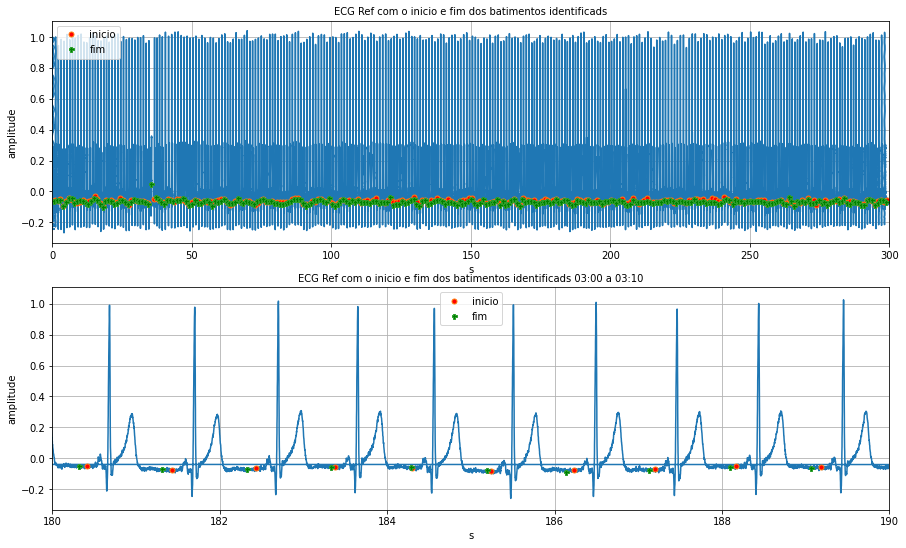

In [20]:
##############################################################
#### Plota e cálcula sinal com inicio e fim dos batimentos ###
##############################################################
ini, end = beats_interval(ecg_ref,idx_beats,0.3)#calula inicio e fim dos batimentos

plt.figure(figsize=(15, 9))
plt.subplot(2, 1, 1)
plt.plot(ecg_time, ecg_ref)
plt.plot(ecg_time, ecg_ref, 'o',markevery=ini, markerfacecolor='r', markersize=5.0, label='inicio')
plt.plot(ecg_time, ecg_ref, 'P',markevery=end, markerfacecolor='g', markersize=5.0, label='fim')
plt.title('ECG Ref com o inicio e fim dos batimentos identificads', fontdict = {'fontsize': 10})
plt.xlabel('s')
plt.xlim([0, 300])
plt.ylabel('amplitude')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(ecg_time, ecg_ref)
plt.plot(ecg_time, ecg_ref, 'o',markevery=ini, markerfacecolor='r', markersize=5.0, label='inicio')
plt.plot(ecg_time, ecg_ref, 'P',markevery=end, markerfacecolor='g', markersize=5.0, label='fim')
plt.title('ECG Ref com o inicio e fim dos batimentos identificads 03:00 a 03:10', fontdict = {'fontsize': 10})
plt.xlabel('s')
plt.ylabel('amplitude')
plt.xlim([3*60, (3*60+10)])
plt.legend()
plt.grid()

Assumindo que os canais estão alinhados extrapolamos os pontos de inicio e fim para os canais X, Y e Z, como apresentado no passo seguinte.

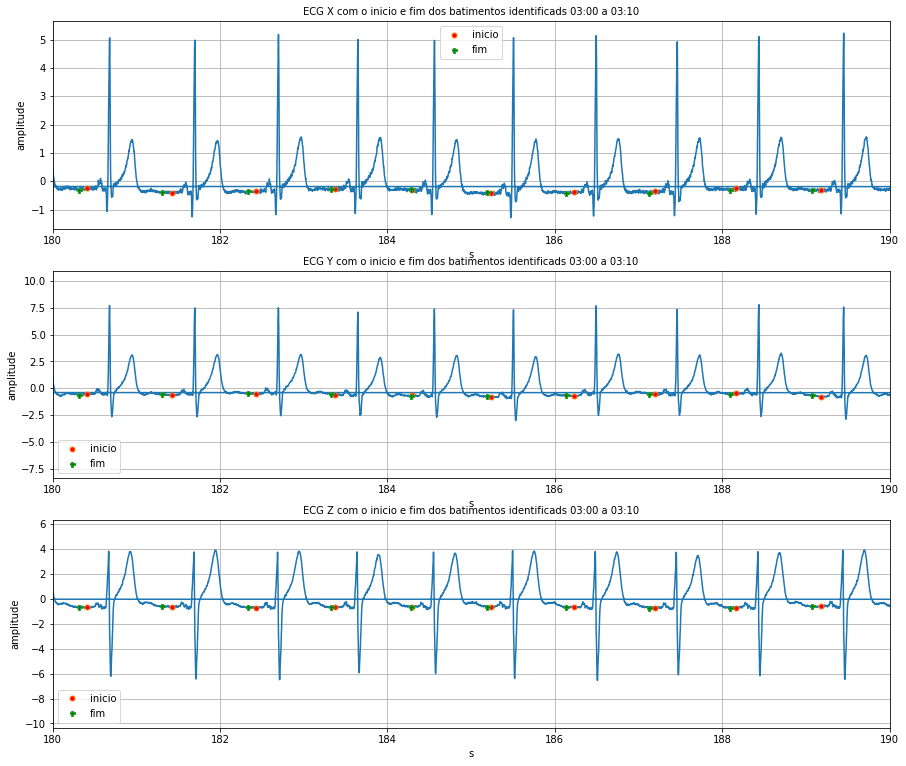

In [21]:
##############################################################
######### Plota sinal com inicio e fim dos batimentos ########
##############################################################
plt.figure(figsize=(15, 13))
plt.subplot(3, 1, 1)
plt.plot(ecg_time, ecg_x)
plt.plot(ecg_time, ecg_x, 'o',markevery=ini, markerfacecolor='r', markersize=5.0, label='inicio')
plt.plot(ecg_time, ecg_x, 'P',markevery=end, markerfacecolor='g', markersize=5.0, label='fim')
plt.title('ECG X com o inicio e fim dos batimentos identificads 03:00 a 03:10', fontdict = {'fontsize': 10})
plt.xlabel('s')
plt.xlim([3*60, (3*60+10)])
plt.ylabel('amplitude')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(ecg_time, ecg_y)
plt.plot(ecg_time, ecg_y, 'o',markevery=ini, markerfacecolor='r', markersize=5.0, label='inicio')
plt.plot(ecg_time, ecg_y, 'P',markevery=end, markerfacecolor='g', markersize=5.0, label='fim')
plt.title('ECG Y com o inicio e fim dos batimentos identificads 03:00 a 03:10', fontdict = {'fontsize': 10})
plt.xlabel('s')
plt.ylabel('amplitude')
plt.xlim([3*60, (3*60+10)])
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(ecg_time, ecg_z)
plt.plot(ecg_time, ecg_z, 'o',markevery=ini, markerfacecolor='r', markersize=5.0, label='inicio')
plt.plot(ecg_time, ecg_z, 'P',markevery=end, markerfacecolor='g', markersize=5.0, label='fim')
plt.title('ECG Z com o inicio e fim dos batimentos identificads 03:00 a 03:10', fontdict = {'fontsize': 10})
plt.xlabel('s')
plt.ylabel('amplitude')
plt.xlim([3*60, (3*60+10)])
plt.legend()
plt.grid()

**2 - Promediação do sinal**  
Para a promediação do sinal foi criada a função *promed*, onde ela utiliza um batimento de referência, nesse caso foi escolhido aleatóriamente, mas ele poderia ter sido inserido de um arquivo externo por exemplo. O sinal de referência será utilizado para a realização da correlação com cada uma das janelas do batimento que foram inseridos, para definir se o batimento vai ser adicionado ou não na promediação pode ser definido qual a porcentagem de correlação deve se ter entre o sinal de referência e o que será promediado.

In [26]:
##############################################################
############ Função para cálculo da promediação ##############
##############################################################
def promed(mat_cycles,sig_ref, c_corr=0.997, n_b=292):

    matrice = pd.DataFrame(mat_cycles)#transforma em um datarame pandas para usar a fução corr
    sig_ref = pd.DataFrame(sig_ref)#mesma coisa que antes
    mat_cor = np.array([])
    for i in range(n_b-2):
        mat_cor = np.append(mat_cor, sig_ref[0].corr(matrice[i]))#realiza a correlação a cada iteração do for
        
    mat_promed = np.array(matrice[0])
    included_cycle = np.array([])
    excluded_cycle = np.array([])
    for j in range(n_b-2):
        if mat_cor[j]>c_corr:#seleciona os ciclos que estão dentro do limite da correlação 
            mat_promed = np.c_[mat_promed, matrice[j]]
            included_cycle = np.append(included_cycle, j)#número do ciclos incluidos na promediação
        else:
            excluded_cycle = np.append(excluded_cycle, j)#número do ciclo excluido na promediação

    return mat_promed, sig_ref, included_cycle, excluded_cycle

Para a realização da promediação, antes foi dividido o sinal em uma matriz de batimentos, contendo assim seus 292 batimentos para cada canal. Após isso escolhemos aleatóriamente o batimento 60 para ser utilizado como referência e colocamos um fator de corelação de 99.7%. 
Após a promediação de cada canal tivemos o seguinte número de amostras incluidas e excluida para cada canal:
* Canal Ref. - 
  * Incluidos - 216
  * Excluidos - 74
* Canal X - 
  * Incluidos - 253
  * Excluidos - 37
* Canal Y - 
  * Incluidos - 239
  * Excluidos - 51
* Canal Z - 
  * Incluidos - 288
  * Excluidos - 2

In [34]:
##############################################################
##### Gera as matrizes de patimentos e promedia o sinal ######
##############################################################
#gerando as matrizes com todos os batimentos para cada canal
cycles_ref = np.array(ecg_ref[ini[1]:end[1]])
cycles_x = np.array(ecg_x[ini[1]:end[1]])
cycles_y = np.array(ecg_y[ini[1]:end[1]])
cycles_z = np.array(ecg_z[ini[1]:end[1]])

for j in range(2, len(idx_beats)-1):
    
    cycles_ref = np.c_[cycles_ref, ecg_ref[ini[j]:end[j]]]
    cycles_x = np.c_[cycles_x, ecg_x[ini[j]:end[j]]]
    cycles_y = np.c_[cycles_y, ecg_y[ini[j]:end[j]]]
    cycles_z = np.c_[cycles_z, ecg_z[ini[j]:end[j]]]

#aplica a função de promediação e retorna o sinal promediado para cda canal
promed_signalref, promed_refref, included_cycleref, excluded_cycleref = promed(cycles_ref,cycles_ref[:,60])
promed_signalx, promed_refx, included_cyclex, excluded_cyclex = promed(cycles_x, cycles_x[:,60])
promed_signaly, promed_refy, included_cycley, excluded_cycley = promed(cycles_y, cycles_y[:,60])
promed_signalz, promed_refz, included_cyclez, excluded_cyclez = promed(cycles_z, cycles_z[:,60])
promed_ref = promed_signalref.mean(1)
promed_x = promed_signalx.mean(1)
promed_y = promed_signaly.mean(1)
promed_z = promed_signalz.mean(1)

A seguir é apresentado os gráficos dos sinais promediados e da referência, podemos ver que o sinal promediado ficou inclusive mais estável que o sinal de referência, isso se deu pois a amostra foi retirado do próprio sinal de maneira aleatória. O resultado poderia ser melhor utilizando um sinal de referência externo completamnte limpo.

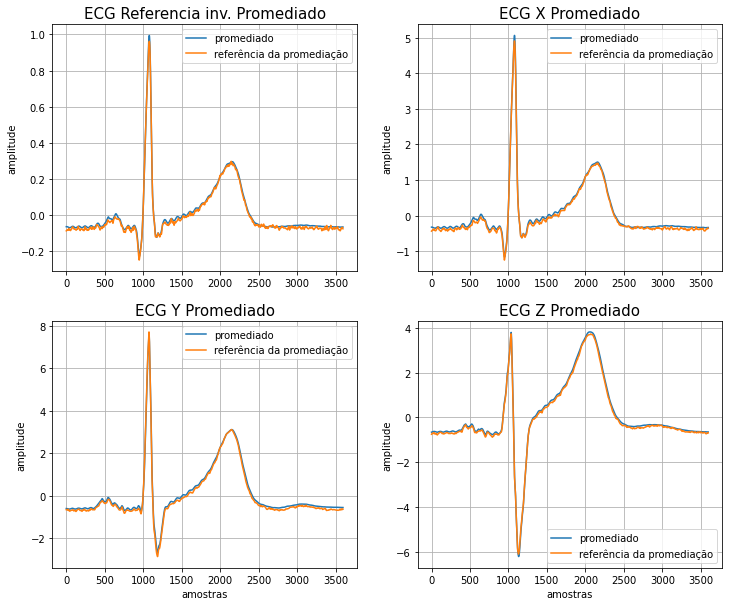

In [39]:
##############################################################
########## Plota os sinais promediados e a referência ########
##############################################################
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(promed_ref, label='promediado')
plt.plot(promed_refref, label='referência da promediação')
plt.title('ECG Referencia inv. Promediado', fontdict = {'fontsize': 15})
plt.ylabel('amplitude')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(promed_x, label='promediado')
plt.plot(promed_refx, label='referência da promediação')
plt.title('ECG X Promediado', fontdict = {'fontsize': 15})
plt.ylabel('amplitude')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(promed_y, label='promediado')
plt.plot(promed_refy, label='referência da promediação')
plt.title('ECG Y Promediado', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.ylabel('amplitude')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(promed_z, label='promediado')
plt.plot(promed_refz, label='referência da promediação')
plt.title('ECG Z Promediado', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.ylabel('amplitude')
plt.legend()
plt.grid()

**2 - Ruído residual**  
Para o cálculo do ruído residual apenas subpraimos do sinal utilizado como referência o sinal promeddiado para cada canal. O resultado pode ser visto a segui.

In [47]:
##############################################################
################## Cálcula o ruído residual ##################
##############################################################
ruido_res_x = (promed_refx[0] - promed_x)
ruido_res_y = (promed_refy[0] - promed_y)
ruido_res_z = (promed_refz[0] - promed_z)
ruido_res_ref = (promed_refref[0] - promed_ref)

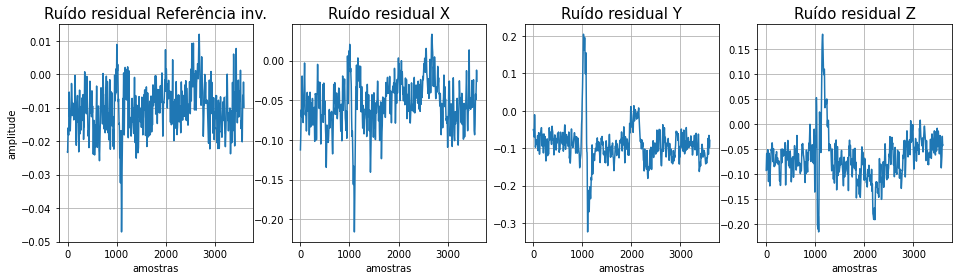

In [48]:
##############################################################
################### Plota o ruido residual ###################
##############################################################
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.plot(ruido_res_ref)
plt.title('Ruído residual Referência inv.', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.ylabel('amplitude')
plt.grid()

plt.subplot(1, 4, 2)
plt.plot(ruido_res_x)
plt.title('Ruído residual X', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.grid()

plt.subplot(1, 4, 3)
plt.plot(ruido_res_y)
plt.title('Ruído residual Y', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.grid()

plt.subplot(1, 4, 4)
plt.plot(ruido_res_z)
plt.title('Ruído residual Z', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.grid()

**2 - Vetor magnitude**  
Para o calculo do vetor magnitude fora implementados filtros Buterwoth de quarta ordem para as frequências solicitadas de 25, 40 e 80 Hz. Os filtros foram aplicados a cada um dos canais como mostrado a seguir.

In [49]:
##############################################################
######### Gera e aplica os filtros de 25, 40 e 80 Hz #########
##############################################################
#gera os filtros
b25, a25 = signal.butter(4, 25/nyq, 'high')
b40, a40 = signal.butter(4, 40/nyq, 'high')
b80, a80 = signal.butter(4, 80/nyq, 'high')

#Aplica cada um dos filtros aos 4 canais
promed_filt_25ref = signal.filtfilt(b25, a25, promed_ref)
promed_filt_40ref = signal.filtfilt(b40, a40, promed_ref)
promed_filt_80ref = signal.filtfilt(b80, a80, promed_ref)

promed_filt_25x = signal.filtfilt(b25, a25, promed_x)
promed_filt_40x = signal.filtfilt(b40, a40, promed_x)
promed_filt_80x = signal.filtfilt(b80, a80, promed_x)

promed_filt_25y = signal.filtfilt(b25, a25, promed_y)
promed_filt_40y = signal.filtfilt(b40, a40, promed_y)
promed_filt_80y = signal.filtfilt(b80, a80, promed_y)

promed_filt_25z = signal.filtfilt(b25, a25, promed_z)
promed_filt_40z = signal.filtfilt(b40, a40, promed_z)
promed_filt_80z = signal.filtfilt(b80, a80, promed_z)

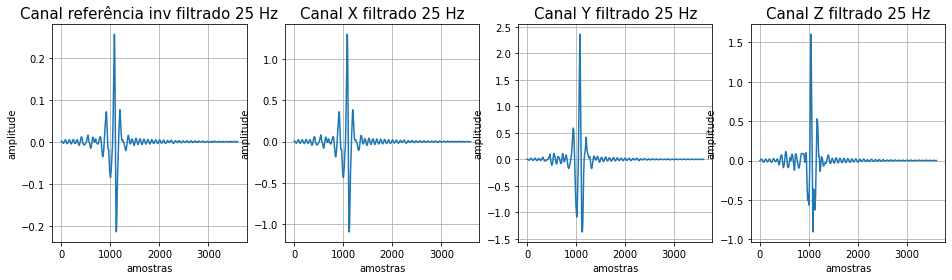

In [50]:
##############################################################
######### Plota sinal filtrado a 25 Hz para cada canal #######
##############################################################
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.plot(promed_filt_25ref)
plt.title('Canal referência inv filtrado 25 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.ylabel('amplitude')
plt.grid()

plt.subplot(1, 4, 2)
plt.plot(promed_filt_25x)
plt.title('Canal X filtrado 25 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.ylabel('amplitude')
plt.grid()

plt.subplot(1, 4, 3)
plt.plot(promed_filt_25y)
plt.title('Canal Y filtrado 25 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.ylabel('amplitude')
plt.grid()

plt.subplot(1, 4, 4)
plt.plot(promed_filt_25z)
plt.title('Canal Z filtrado 25 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.ylabel('amplitude')
plt.grid()

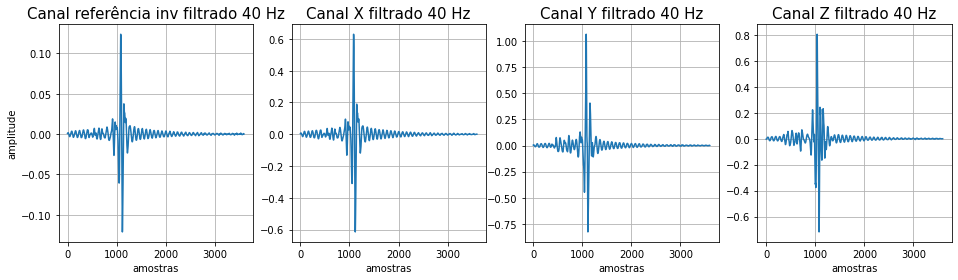

In [51]:
##############################################################
######### Plota sinal filtrado a 40 Hz para cada canal #######
##############################################################
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.plot(promed_filt_40ref)
plt.title('Canal referência inv filtrado 40 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.ylabel('amplitude')
plt.grid()

plt.subplot(1, 4, 2)
plt.plot(promed_filt_40x)
plt.title('Canal X filtrado 40 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.grid()

plt.subplot(1, 4, 3)
plt.plot(promed_filt_40y)
plt.title('Canal Y filtrado 40 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.grid()

plt.subplot(1, 4, 4)
plt.plot(promed_filt_40z)
plt.title('Canal Z filtrado 40 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.grid()

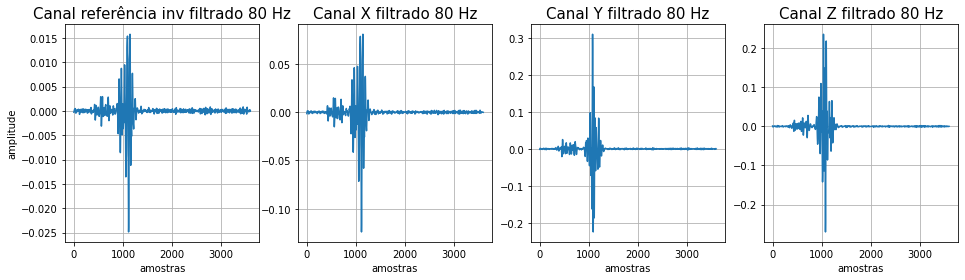

In [52]:
##############################################################
######### Plota sinal filtrado a 80 Hz para cada canal #######
##############################################################
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.plot(promed_filt_80ref)
plt.title('Canal referência inv filtrado 80 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.ylabel('amplitude')
plt.grid()

plt.subplot(1, 4, 2)
plt.plot(promed_filt_80x)
plt.title('Canal X filtrado 80 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.grid()

plt.subplot(1, 4, 3)
plt.plot(promed_filt_80y)
plt.title('Canal Y filtrado 80 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.grid()

plt.subplot(1, 4, 4)
plt.plot(promed_filt_80z)
plt.title('Canal Z filtrado 80 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.grid()

Após o cálculo dos sinais filtrados podemos então calcular devidamente o vetor magnitude, que nada mais é que a raiz quadrada do somatório ao quadrado do sinal filtrado de cada canal para cada frequência, conforme
equação abaixo.

![vetormagnitude](mag_vet.png)  

Com isso podemos calcular o vetor para cada uma das frequências desejadas, como é apresentado nos passos a seguir.

In [53]:
##############################################################
## calculando os vetores magnitudaes cara cada frequencia ####
##############################################################
mag25 = np.sqrt(promed_filt_25ref**2 + promed_filt_25x**2 + promed_filt_25y**2 + promed_filt_25z**2)
mag40 = np.sqrt(promed_filt_40ref**2 + promed_filt_40x**2 + promed_filt_40y**2 + promed_filt_40z**2)
mag80 = np.sqrt(promed_filt_80ref**2 + promed_filt_80x**2 + promed_filt_80y**2 + promed_filt_80z**2)

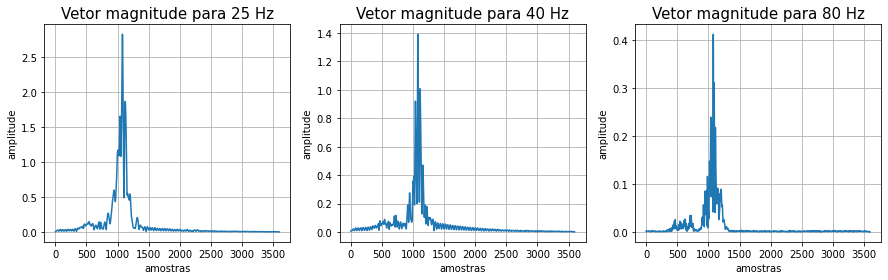

In [54]:
##############################################################
############## Plota os vetores magnitudes ###################
##############################################################
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(mag25)
plt.title('Vetor magnitude para 25 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.ylabel('amplitude')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(mag40)
plt.title('Vetor magnitude para 40 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.ylabel('amplitude')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(mag80)
plt.title('Vetor magnitude para 80 Hz', fontdict = {'fontsize': 15})
plt.xlabel('amostras')
plt.ylabel('amplitude')
plt.grid()

**3 - Determinar intervalo RR**  
Para determinar os intervalo RR antes precisamos identificar os picos da onda R, para isso foi feita a função *find_r*, que foi implementada praticamente da mesma maneira que a função para identificar os batimentos. A diferença nessa função voi elevar o sinal ao quadrado de modo que o pico R que é o de maior amplitude no sinal, ficasse ainda maior se dastacando dos demais, assin a função *find_peaks* idia ter mais acertividade na sua busca. O limite para essa implemtação foi de picos a cima de 75% do máximo do sinal. Como pode ser Visto a Seguir

In [55]:
##############################################################
############### Função para identificação Pico R #############
##############################################################
def find_r(ecg):
    ecg_ar = np.array(ecg)#inicializa
    ecg = list(ecg)
    sign = np.where(ecg_ar > 0, 1, -1)#cria um vetor com 1 e -1 para manter a polaridade do sinal depois
    ecg_sq = [item ** 2 for item in ecg]#calcula o quadrado de cada ponto do sinal
    ecg_sq = ecg_sq * sign#rretorna os picos negativos que estavam positivos
    lim = max(ecg_sq)*0.75#define o limite inferior para encontra os picos
    peaks, _= find_peaks(ecg_sq, distance=100, height=lim)#encontra os picos
    
    return peaks

Após a identificação dos picos R, para a identificação do intervalo apenas calculamos a diferença entre os picos R consecultivos e dividimos pela frequência de amostragem, tendo assim o tempo em segundos.

In [56]:
##############################################################
############## calculando picos R e intervalo RR #############
##############################################################
RR_picos = find_r(ecg_ref)
RR = np.ediff1d(RR_picos)# Os intervalor RR sao definidos pela diferença de amostra entre cada pico
RR = (RR/fs_interp)

A seguir são plotados os picos R para cada um dos canais.

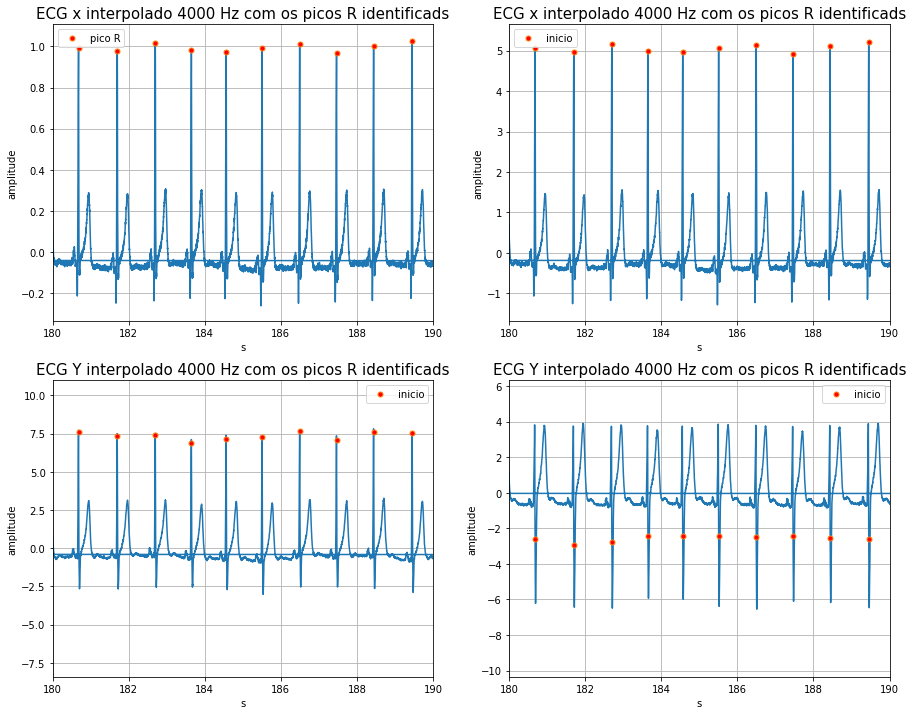

In [57]:
##############################################################
########## Plota os sinais com os picos R indicados ##########
##############################################################
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.plot(ecg_time, ecg_ref)
plt.plot(ecg_time, ecg_ref, 'o',markevery=(RR_picos), markerfacecolor='r', markersize=5.0, label='pico R')
plt.title('ECG x interpolado 4000 Hz com os picos R identificads', fontdict = {'fontsize': 15})
plt.xlabel('s')
plt.xlim([3*60, (3*60+10)])
plt.ylabel('amplitude')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(ecg_time, ecg_x)
plt.plot(ecg_time, ecg_x, 'o',markevery=(RR_picos), markerfacecolor='r', markersize=5.0, label='inicio')
plt.title('ECG x interpolado 4000 Hz com os picos R identificads', fontdict = {'fontsize': 15})
plt.xlabel('s')
plt.xlim([3*60, (3*60+10)])
plt.ylabel('amplitude')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(ecg_time, ecg_y)
plt.plot(ecg_time, ecg_y, 'o',markevery=(RR_picos), markerfacecolor='r', markersize=5.0, label='inicio')
plt.title('ECG Y interpolado 4000 Hz com os picos R identificads', fontdict = {'fontsize': 15})
plt.xlabel('s')
plt.ylabel('amplitude')
plt.xlim([3*60, (3*60+10)])
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(ecg_time, ecg_z)
plt.plot(ecg_time, ecg_z, 'o',markevery=(RR_picos), markerfacecolor='r', markersize=5.0, label='inicio')
plt.title('ECG Y interpolado 4000 Hz com os picos R identificads', fontdict = {'fontsize': 15})
plt.xlabel('s')
plt.ylabel('amplitude')
plt.xlim([3*60, (3*60+10)])
plt.legend()
plt.grid()

A seguir é apresentado os intervamos RR em milisegundos como o pedido

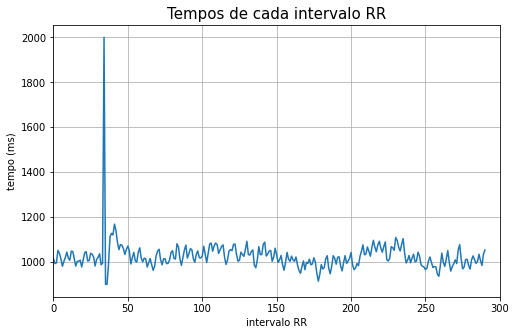

In [59]:
##############################################################
############### Apresenta todos os intervalos RR #############
##############################################################
plt.figure(figsize=(8, 5))
plt.plot(RR*1000)
plt.title('Tempos de cada intervalo RR', fontdict = {'fontsize': 15})
plt.xlabel('intervalo RR')
plt.xlim([0, 300])
plt.ylabel('tempo (ms)')
plt.grid()

**4 - Cálculo QT e QTc**  
Para o cálculo dos intervalos QT antes de tudo encontramos os picos Q e T, adicionalmente identificamos também os picos P e S com a função *find_q_s_t_p*. Para a implementação da função tomamos como base os intervalos R já identificados, encontramos então todos os picos do sinal. Para encontrar o ponto Q é feita uma busca a partir do ponto do pico R para as amostras anteriores buscando o mínimo, já para o S identificamos o minimo após o pico R, para o T identificamos o próximo maior pico após o pico R, e por fim para o pico P identificamos o maior pico anterior ao ponto Q.

In [62]:
##############################################################
########## Função para identificação dos picos PQST ##########
##############################################################
def find_q_s_t_p(r, arr):
    #dados de inicialização e para retorno
    q = []
    s = []
    theta_peak = []
    p_peak = []
    sign = np.where(arr > 0, 1, -1)
    ecg_sq = [item ** 2 for item in arr]
    ecg_sq = ecg_sq * sign
    all_peaks = find_peaks(ecg_sq)
    is_first = True
    #ecg_after_wavelet = wavelets(ecg_sq)
    s_pos = 0
    #for para iterar sobre o sinal atualizando a posição
    for i in r:
        pos = i
        while arr[pos] >= arr[pos - 1]:
            pos = pos - 1
        q.append(pos)
        pos = i
        while pos + 1 != len(arr) and arr[pos] >= arr[pos + 1]:
            pos = pos + 1
        if pos + 1 == len(arr):
            break
        s.append(pos)

        if not is_first:
            cur = q[s_pos]
            #             wave_mins, _ = find_peaks(ecg_after_wavelet*(-1))
            sub_ar_for_theta_peak = list(arr[prev:int(round((cur - prev) * 0.6) + prev)])
            sub_ar_for_p_peak = list(arr[int(round((cur - prev) * 0.6) + prev):cur])
            theta_peak.append(sub_ar_for_theta_peak.
                              index(max(sub_ar_for_theta_peak)) + prev)
            p_peak.append(int(sub_ar_for_p_peak.
                              index(max(sub_ar_for_p_peak)) + prev + round((cur - prev) * 0.6)))

        prev = s[s_pos]
        s_pos += 1
        is_first = False
    return np.array(q), np.array(s), np.array(theta_peak), np.array(p_peak)


#def wavelets(ecg, lev_to_decompose=10, lev_to_recontr=5):
#    decontr = pywt.wavedec(ecg, 'sym4', 'ppd', lev_to_decompose)
#    reconstr = pywt.waverec(decontr[:-lev_to_recontr] + [None] * lev_to_recontr, 'sym4')
#    return reconstr

Com a função inplementada calculamos então os picos para o sinal de referência e extrapolamos eles para os demais sinais

In [64]:
##############################################################
################## Identifica os picos PQST ##################
##############################################################
Q_peak, S_peak, T_peak, P_peak = find_q_s_t_p(RR_picos, ecg_ref)

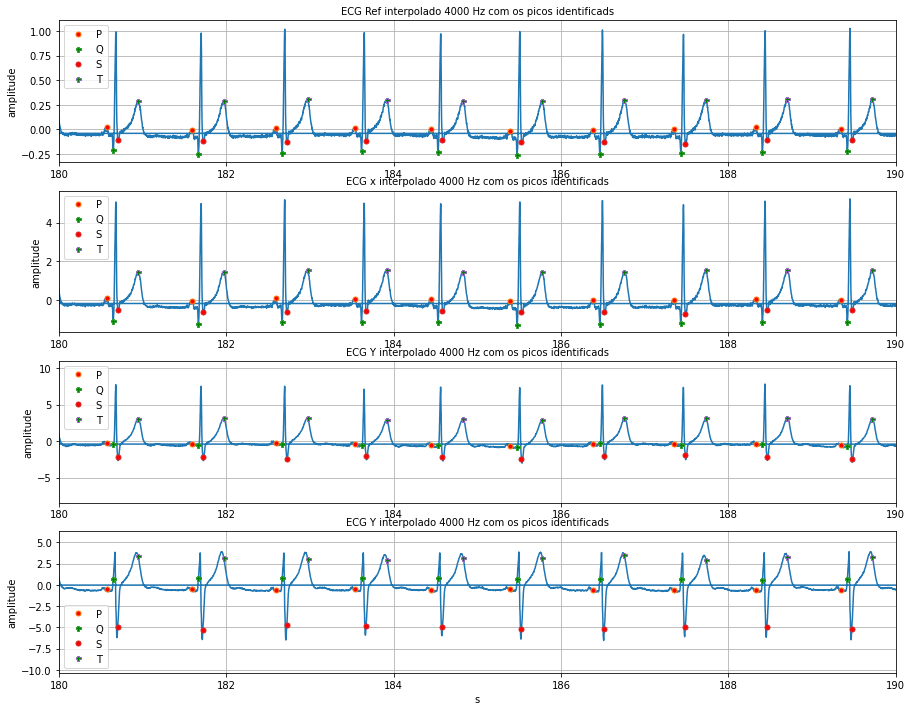

In [65]:
##############################################################
######### Plota os canais com os picos identificados #########
##############################################################
plt.figure(figsize=(15, 12))

#q, s, theta_peak, p_peak 
plt.subplot(4, 1, 1)
plt.plot(ecg_time, ecg_ref)
plt.plot(ecg_time, ecg_ref, 'o',markevery=P_peak, markerfacecolor='r', markersize=5.0, label='P')
plt.plot(ecg_time, ecg_ref, 'P',markevery=Q_peak, markerfacecolor='g', markersize=5.0, label='Q')
plt.plot(ecg_time, ecg_ref, 'o',markevery=S_peak, markerfacecolor='r', markersize=5.0, label='S')
plt.plot(ecg_time, ecg_ref, 'P',markevery=T_peak, markerfacecolor='g', markersize=5.0, label='T')
plt.title('ECG Ref interpolado 4000 Hz com os picos identificads', fontdict = {'fontsize': 10})
plt.xlim([3*60, (3*60+10)])
plt.ylabel('amplitude')
plt.legend()
plt.grid()

#q, s, theta_peak, p_peak 
plt.subplot(4, 1, 2)
plt.plot(ecg_time, ecg_x)
plt.plot(ecg_time, ecg_x, 'o',markevery=P_peak, markerfacecolor='r', markersize=5.0, label='P')
plt.plot(ecg_time, ecg_x, 'P',markevery=Q_peak, markerfacecolor='g', markersize=5.0, label='Q')
plt.plot(ecg_time, ecg_x, 'o',markevery=S_peak, markerfacecolor='r', markersize=5.0, label='S')
plt.plot(ecg_time, ecg_x, 'P',markevery=T_peak, markerfacecolor='g', markersize=5.0, label='T')
plt.title('ECG x interpolado 4000 Hz com os picos identificads', fontdict = {'fontsize': 10})
plt.xlim([3*60, (3*60+10)])
plt.ylabel('amplitude')
plt.legend()
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(ecg_time, ecg_y)
plt.plot(ecg_time, ecg_y, 'o',markevery=P_peak, markerfacecolor='r', markersize=5.0, label='P')
plt.plot(ecg_time, ecg_y, 'P',markevery=Q_peak, markerfacecolor='g', markersize=5.0, label='Q')
plt.plot(ecg_time, ecg_y, 'o',markevery=S_peak, markerfacecolor='r', markersize=5.0, label='S')
plt.plot(ecg_time, ecg_y, 'P',markevery=T_peak, markerfacecolor='g', markersize=5.0, label='T')
plt.title('ECG Y interpolado 4000 Hz com os picos identificads', fontdict = {'fontsize': 10})
plt.ylabel('amplitude')
plt.xlim([3*60, (3*60+10)])
plt.legend()
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(ecg_time, ecg_z)
plt.plot(ecg_time, ecg_z, 'o',markevery=P_peak, markerfacecolor='r', markersize=5.0, label='P')
plt.plot(ecg_time, ecg_z, 'P',markevery=Q_peak, markerfacecolor='g', markersize=5.0, label='Q')
plt.plot(ecg_time, ecg_z, 'o',markevery=S_peak, markerfacecolor='r', markersize=5.0, label='S')
plt.plot(ecg_time, ecg_z, 'P',markevery=T_peak, markerfacecolor='g', markersize=5.0, label='T')
plt.title('ECG Y interpolado 4000 Hz com os picos identificads', fontdict = {'fontsize': 10})
plt.xlabel('s')
plt.ylabel('amplitude')
plt.xlim([3*60, (3*60+10)])
plt.legend()
plt.grid()

A partir dos bontos identificados para a realização do cálculo dos intervalos, foi implementado a função *interval*, ela encontra o intervalos de varios seguimentos do sinal, a sua lógica é a partir do pico identificado, estabelecer uma janela para identificar o inicio e final em cada uma das ondas, e a partir dai subtraimos os inicios e fins para cada intervalo desejado. No nosso caso o intervalo de intresse é o intervalo QT, que no caso é o intervalo do inicio da onda Q até o fina da onda T. 

In [66]:
##############################################################
######## Funcoes para calcular intervalos das ondas ##########
##############################################################
#função para transladar o ponto para a origem
def point_transform_to_origin(por,point):
    point_from_origin = por + point 
    return point_from_origin

#função para calcular o intervalo da onda com tempo de inicio e fim
def sub_signal_interval(time, start_point, end_point,point_from_origin=0):
    start_point = point_transform_to_origin(point_from_origin,start_point)
    end_point = point_transform_to_origin(point_from_origin,end_point)
    
    return float(abs(time[end_point]-time[start_point]))

#função para gerar a saídas de vários intervalos de interesse do complexo PQRST
def interval(P, Q, R, S, T, time):
    
    length_R = len(R)*.9
    QRS = []
    P_Q = []
    Q_T = []
    P_R = []
    S_T = []
    R_T = []
    P_T = []

    for i in range(0, len(R)-1):

        qrs = sub_signal_interval(time,int(Q[i]-(length_R/2.5)),int(S[i]+(length_R/2.5)))
        QRS.append(qrs)

        q_t = sub_signal_interval(time,int(Q[i]-length_R),int(T[i]+length_R))
        Q_T.append(q_t)
       
        p_q = sub_signal_interval(time,int(P[i]-length_R),int(Q[i]+length_R))
        P_Q.append(p_q)
       
        p_r = sub_signal_interval(time,int(P[i]-length_R),int(R[i]+length_R))
        P_R.append(p_r)

        s_t = sub_signal_interval(time,int(S[i]-length_R),int(T[i]+length_R))
        S_T.append(s_t)

        r_t = sub_signal_interval(time,int(R[i]-length_R),int(T[i]+length_R))
        R_T.append(r_t)

        p_t = sub_signal_interval(time,int(P[i]-length_R),int(T[i]+length_R))
        P_T.append(p_t)
  
    return np.array(Q_T), np.array(QRS), np.array(P_Q), np.array(P_R), np.array(S_T), np.array(R_T), np.array(P_T)

Para o cálculo do intervalo QTc foram utilizado os métodos de Bazett (que computa o QTc a partir do intervalo QT dividido pela raiz quadrada do intervalo RR), e o método de Friderichia (que computa o QTc a partir do intervalo QT dividido pela raiz cúbica do intervalo RR). A seguir apresentamos os cálculos e os tempos finais para cada um dos intervalos

In [68]:
##############################################################
####################### calculando QT e QTc ##################
##############################################################
Q_T, QRS, P_Q, P_R, S_T, R_T, P_T = interval(P_peak, Q_peak, RR_picos, S_peak, T_peak, ecg_time)
QTcB = Q_T[1:]/np.sqrt(RR[1:])
QTcF = Q_T[1:]/np.cbrt(RR[1:])

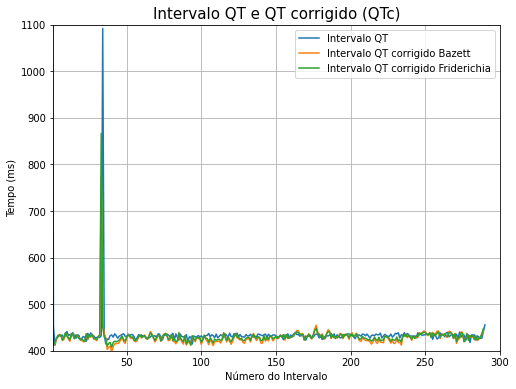

In [70]:
##############################################################
################### Plota intervalos QT e QTc#################
##############################################################
plt.figure(figsize=(8, 6))
plt.subplot(1, 1, 1)
plt.plot(Q_T*1000, label='Intervalo QT')
plt.plot(QTcB*1000, label='Intervalo QT corrigido Bazett')
plt.plot(QTcF*1000, label='Intervalo QT corrigido Friderichia')
plt.title('Intervalo QT e QT corrigido (QTc)', fontdict = {'fontsize': 15})
plt.xlabel('Número do Intervalo')
plt.xlim([1, 300])
plt.ylabel('Tempo (ms)')
plt.ylim([400, 1100])
plt.legend()
plt.grid()

A seguir também é apresentado o intervalo QRS do sinal

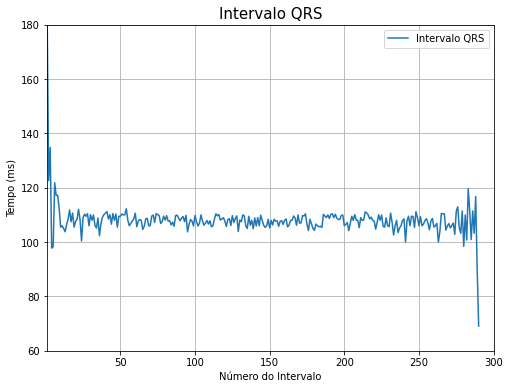

In [71]:
##############################################################
################### Plota intervalo QRS ######################
##############################################################
plt.figure(figsize=(8, 6))
plt.subplot(1, 1, 1)
plt.plot(QRS*1000, label='Intervalo QRS')
plt.title('Intervalo QRS', fontdict = {'fontsize': 15})
plt.xlabel('Número do Intervalo')
plt.xlim([1, 300])
plt.ylabel('Tempo (ms)')
plt.ylim([60, 180])
plt.legend()
plt.grid()

**5 - Cálculos estátisticos do sinal**  
Para o cálculo das métricas solicitadas, anteriormente se implementou o filtro de média móvel com a função *MA_filter* ele recebe o sinal e o numero de pontos para cálculo da sáida.  
O filtro de média móvel filtro passa baixa, onde ele recebe L amostras como entrada fazendo a média destas L amostras e produzindo um único ponto como saida. Conforme o tamanho do parâmetro L aumenta a suavização da saída aumenta, porem os sinais podem perder informações importantes, desse modo deve se analisar o objetivo final para definir o parametro L. O filtro apresenta uma excelente resposta no domínio do tempo, porém sua resposta no domínio de frequência acaba não sendo interessante.  
Para a implementação desse filtro realizamos a convolução do sinal com uma janela unitária do tamanho solicitado, como apresentado a seguir.

In [74]:
##############################################################
#################### Filtro média móvel ######################
##############################################################
def MA_filter(s,n):
    
    window = np.ones(n)/n#criando janela
    npad = len(window) - 1

    u_padded = np.pad(s, (npad//2, npad - npad//2), mode='constant')

    r = np.convolve(s, window, 'valid')#aplicando convolução
    return r

In [75]:
RR_ma3 = MA_filter(RR,3);

Após o cálculo da média móvel para 3 pontos podemos ver a sáida a seguir

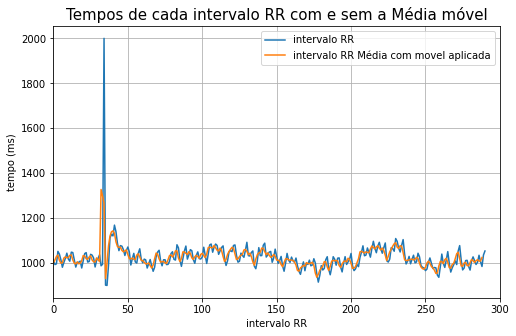

In [77]:
##############################################################
############ Plotando média móvel e sinal original ###########
##############################################################
plt.figure(figsize=(8, 5))
plt.plot(RR*1000, label = 'intervalo RR')
plt.plot(RR_ma3*1000, label = 'intervalo RR Média com movel aplicada')
plt.title('Tempos de cada intervalo RR com e sem a Média móvel', fontdict = {'fontsize': 15})
plt.xlabel('intervalo RR')
plt.xlim([0, 300])
plt.ylabel('tempo (ms)')
plt.legend()
plt.grid()

Para cálculo da média, desvio padrão, variância e valor RMS dos sinais RR original e filtrado utilizando
filtro MA de 3 termos, realizamos a soma dos picos RR para criar os vetores de tempo de 1 em 1 minuto até os 5 minutps, após isso foi realizado o cálculo de média, desvio padrão, variância e valor RMS utilizando funções próprias da bibliotema *numpy*, conforme apresentado a seguir.

In [102]:
##############################################################
########## Preparando para cálculo das estatísticas ##########
##############################################################
mean_mm = np.array([])
mean = np.array([])
dpad_mm = np.array([])
dpad = np.array([])
varr_mm = np.array([])
varr = np.array([])
rms_mm = np.array([])
rms = np.array([])
#somatório do s intervalos RR
RR_sum = np.cumsum(RR)
#montagem dos intervalos de 1 em 1 minuto
minuto = np.array([RR_sum[0:60], RR_sum[60:(2*60)], RR_sum[(2*60):(3*60)], 
                 RR_sum[(2*60):(3*60)], RR_sum[(3*60):(4*60)], RR_sum[(4*60):(5*60)]])

/home/ieb-doc/.conda/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [108]:
##############################################################
################## Cálculando as estatísticas ################
##############################################################
for i in range(5):
    #média
    mean_mm = np.append(mean_mm, np.mean(RR_ma3[int(minuto[i][1]):int(minuto[i][-1])]))
    mean = np.append(mean, np.mean(RR[int(minuto[i][1]):int(minuto[i][-1])]))
    #desvio padrão
    dpad_mm = np.append(dpad_mm, np.std(RR_ma3[int(minuto[i][1]):int(minuto[i][-1])]))
    dpad = np.append(dpad, np.std(RR[int(minuto[i][1]):int(minuto[i][-1])]))
    #variância
    varr_mm = np.append(varr_mm, np.var(RR_ma3[int(minuto[i][1]):int(minuto[i][-1])]))
    varr = np.append(varr, np.var(RR[int(minuto[i][1]):int(minuto[i][-1])]))
    #RMS
    rms_mm = np.append(rms_mm, np.sqrt(np.mean(np.square(RR_ma3[int(minuto[i][1]):int(minuto[i][-1])]))))
    rms = np.append(rms, np.sqrt(np.mean(np.square(RR[int(minuto[i][1]):int(minuto[i][-1])]))))

In [119]:
##############################################################
############# Mostrando na tela as estatísticas ##############
##############################################################
for i in range(5):
    print('RR min('+str(i+1)+'):\nMédia: '+str(round(mean[i],4))+'  Desvio padrão: '+str(round(dpad[i],4))+
          ' variância: '+str(round(varr[i],4))+'  RMS: '+str(round(rms[i],4))+'\n')
    print('RR filtrado min('+str(i+1)+'):\nMédia: '+str(round(mean_mm[i], 4))+
          '  Desvio padrão: '+str(round(dpad_mm[i],4))+' variância: '+str(round(varr_mm[i],4))+
          '  RMS: '+str(round(rms_mm[i],4))+'\n')

RR min(1):
Média: 1.0448  Desvio padrão: 0.1328 variância: 0.0176  RMS: 1.0532

RR filtrado min(1):
Média: 1.0446  Desvio padrão: 0.0688 variância: 0.0047  RMS: 1.0469

RR min(2):
Média: 1.0335  Desvio padrão: 0.0311 variância: 0.001  RMS: 1.034

RR filtrado min(2):
Média: 1.0335  Desvio padrão: 0.0235 variância: 0.0006  RMS: 1.0338

RR min(3):
Média: 1.0115  Desvio padrão: 0.0358 variância: 0.0013  RMS: 1.0122

RR filtrado min(3):
Média: 1.0102  Desvio padrão: 0.0297 variância: 0.0009  RMS: 1.0107

RR min(4):
Média: 1.0115  Desvio padrão: 0.0358 variância: 0.0013  RMS: 1.0122

RR filtrado min(4):
Média: 1.0102  Desvio padrão: 0.0297 variância: 0.0009  RMS: 1.0107

RR min(5):
Média: 1.0323  Desvio padrão: 0.0365 variância: 0.0013  RMS: 1.033

RR filtrado min(5):
Média: 1.0321  Desvio padrão: 0.0305 variância: 0.0009  RMS: 1.0326



**6 - Intervalo RR dentro do limite de 2 desvios padroes a cima e a baixo**  
Para realizar essa operação antes de tudo se cálculou a média e o desvio padrao de todo o vetor de intervalos RR, a partir desse valor definiu-se os intervalos superiores e inferiores para se realizar a seleção dos valores inseridos e excluidos do vetor. A seguir é apresentado o cálculo dos intervalos assim como a seleção dos sinais dentro da faixa, apresentando gráficamente o resultado na sequência.

In [120]:
##############################################################
######### Cálculando media e dpad para intervalo selec #######
##############################################################
media_RR = np.mean(RR)
desvio_RR = np.std(RR)

inf_mean_dpad = media_RR-(2*desvio_RR)
sup_mean_dpad = media_RR+(2*desvio_RR)

RR_select = np.array([])
for item in RR:
    if item>inf_mean_dpad and item<sup_mean_dpad: 
        RR_select = np.append(RR_select, item )

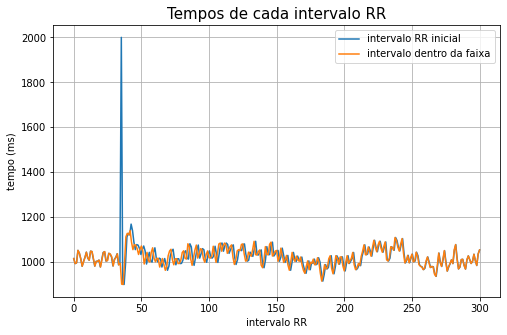

In [121]:
##############################################################
######## Plotando intervalos originais e selecionados ########
##############################################################
x1 = np.linspace(0,1,len(RR))
x2 = np.linspace(0,1,len(RR_select))

plt.figure(figsize=(8, 5))
plt.plot(x1*300, RR*1000, label = 'intervalo RR inicial')
plt.plot(x2*300, RR_select*1000, label = 'intervalo dentro da faixa')
plt.title('Tempos de cada intervalo RR', fontdict = {'fontsize': 15})
plt.xlabel('intervalo RR')
plt.ylabel('tempo (ms)')
plt.legend()
plt.grid()